# Задача прогнозирования бизнес-показателя Банка, связанного с краткосрочной ликвидностью
### 2 команда
1. Дари-Канда Гармаева
2. Антон Пеньков
3. Надежда Калмыкова
4. Леонид Шерстюк

Все процедуры для предсказания содержатся в файле ```model.py```.  
Для работы скрипта необходимо установить пакеты:

In [ ]:
!pip install -r requirements.txt 

Для предсказания значений на все даты, имеющиеся в файле с целевой переменной, требуется передать путь к файлу в функцию ```general_loop()```.  
Для предсказания значения на конкретную дату, требуется передать дату в формате ```YYYY-MM-DD``` и путь к файлу в функцию ```predict_one_day()```.

Примеры вызовов:  
```import model; general_loop('project_3_train+test.xlsx')```   
```import model; predict_one_day('2018-02-06' ,'project_3_train+test.xlsx')```

---

Загрузим данные.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import tsfresh
import json
import datetime
from model import *
from cumsum import *
import ruptures as rpt

In [ ]:
data = pd.read_excel('project_3_train+test.xlsx', index_col='Date')

Поделим данные на трейн и тест по году: в трейн пойдёт 2017й год, в тест - 2018.

In [ ]:
train = data.iloc[:357]
test = data.iloc[357:]

Посмотрим, как выглядят полностью изначальные данные.

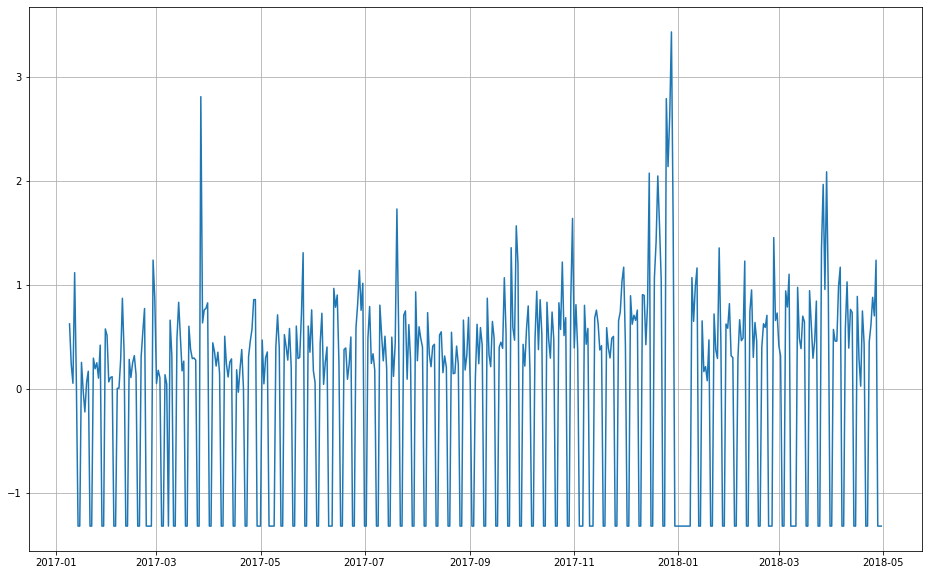

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(data['Target'])
plt.grid()
plt.show()

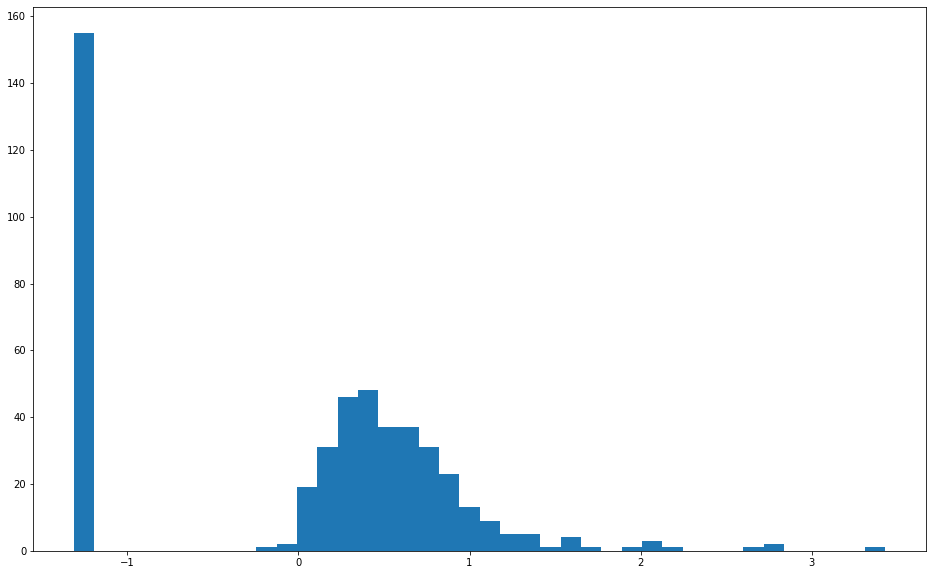

In [ ]:
plt.figure(figsize=(16,10))
plt.hist(data['Target'].values, bins=40)
plt.show()

Столбец слева и сильнейшие колебания в отрицательные значения говорят о том, что что-то не так.

Если заглянуть в файл и календарь, то можно увидеть, что это одно и то же значение и оно стоит на выходном дне.

Посмотрим на данные, без этого значения.

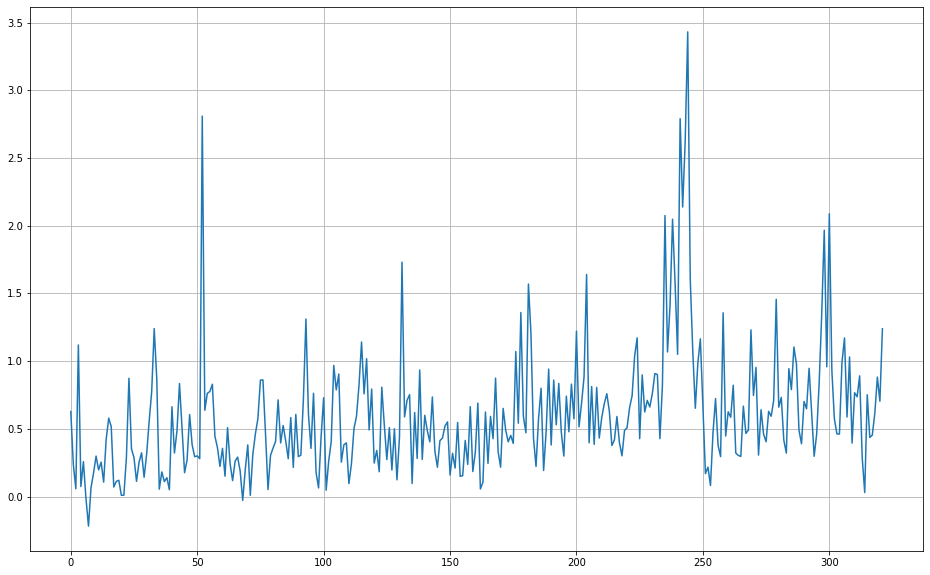

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(data['Target'].values[data['Target'] != data['Target'].values.min()])
plt.grid()
plt.show()

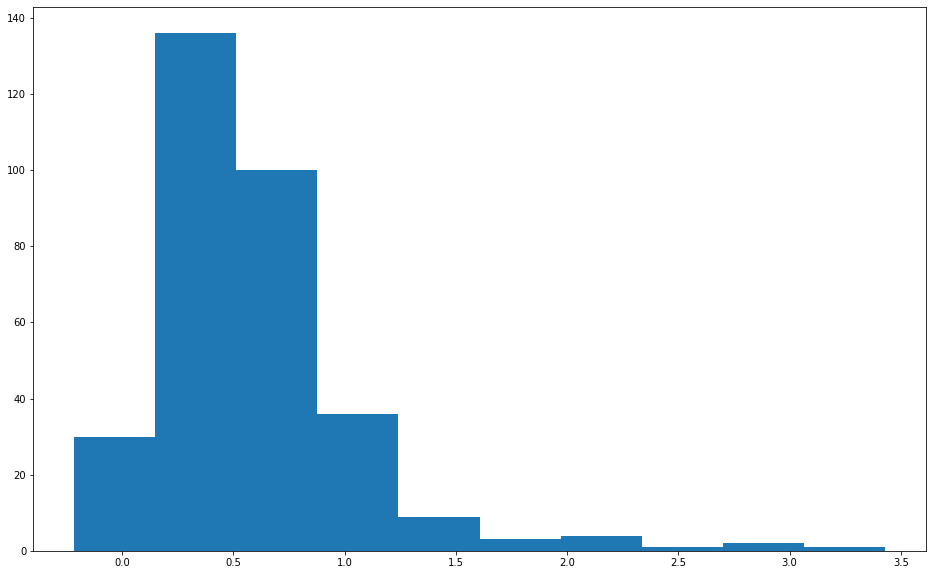

In [ ]:
plt.figure(figsize=(16,10))
plt.hist(data['Target'].values[data['Target'] != data['Target'].values.min()])
plt.show()

Получили картинку, похожую на правду. Переобозначим данные.

In [ ]:
data = data[data['Target'] != data['Target'].min()]
train = train[train['Target'] != train['Target'].min()]
test = test[test['Target'] != test['Target'].min()]

Видим, что ликвидность нарастает к концу года, а в начале года она спадает и возвращается к прежней форме.

# Feature engineering

**В качестве дополнительных данных, которые мы взяли с сайтов investing.com и cbr.ru, для генерации признаков мы использовали следующие показатели:**


- Индекс московской биржи (IMOEX)
- Курс доллар/рубль (USDRUB)
- Цена барреля нефти марки Brent (BRENT)

    **В том числе, факторы формирования ликвидности банковского сектора:**

- Процентный коридор Банка России и ставки сегмента овернайт денежного рынка (ключевая ставка Банка России, нижняя граница (ставка по депозитам постоянного действия), верхняя граница «Репо и кредиты (кр. кредитов овернайт)», верхняя граница «Кредиты овернайт», MIACR, RUONIA)
- Изменение наличных денег в обращении (вне Банка России)
- Изменение остатков средств на счетах расширенного правительства в Банке России и прочие операции
- Движение средств по государственному внутреннему долгу
- Изменение задолженности банков по депозитам Федерального казначейства
- Изменение задолженности банков по операциям репо Федерального казначейства
- Операции Минфина России по покупке (продаже) иностранной валюты на внутреннем валютном рынке
- Регулирование Банком России обязательных резервов кредитных организаций
- Операции Банка России на внутреннем валютном рынке
- Нетто-объем операций Банка России по предоставлению и абсорбированию ликвидности (без учета операций на внутреннем валютном рынке)
    
    **Также мы попробовали сгенерировать признак приближения налоговых выплат по НДС и налога на прибыль, которые платятся поквартально ( до 25 числа месяца, следующего за кварталом)  и ежегодно соответственно (до 28 марта следующего года). Для этого налоговым дням мы поставили в соответствие единицы, а остальные дни апрроксимировали к единице в зависимости от приближения к налоговым дням**


После этого с помощью tsfresh мы генерировали фичи, отфильтровали те, которые нам будут полезны в дальнейшнем. 


# Anomaly detection

В качестве детектора разладки мы использовали методы, представленые в модуле _ruptures_. Мы использовали: 

 - [метод динамического программирования](https://arxiv.org/abs/1907.06810), 
 - [метод Pelt](https://arxiv.org/pdf/1101.1438.pdf),   
 - [метод бинарной сегментации](https://arxiv.org/pdf/1411.0858.pdf),
 - [метод Bottom-Up](http://eprints.lse.ac.uk/25216/1/Unbalanced_Haar_technique_for_nonparametric_function_estimation_%28LSERO%29.pdf),
 - [метод окна](http://ctruong.perso.math.cnrs.fr/ruptures-docs/build/html/detection/window.html),
 - метод кумулятивных сумм.
 
Каждый метод возвращал некоторый набор точек разладки, а мы брали из них самые популярные.

Посмотрим, что мы получили на уже имеющихся данных

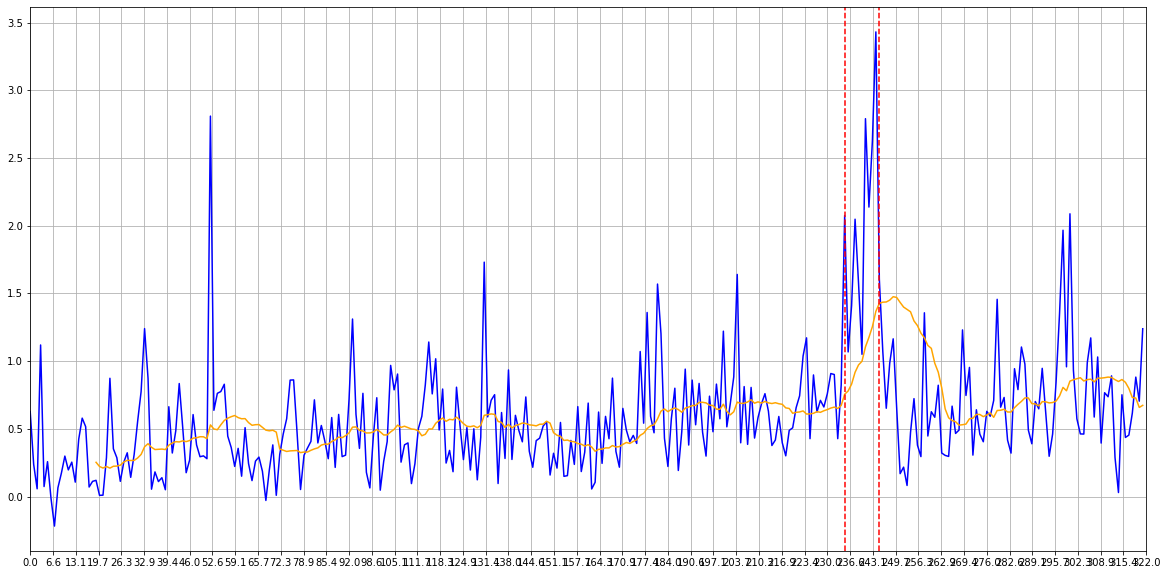

In [ ]:
change = get_change_point(data['Target'].values)
rolling_mean = data['Target'].rolling(window=20).mean().values
plt.figure(figsize=(20,10))
plt.plot(data['Target'].values, color='blue')
plt.plot(rolling_mean, color = 'orange')
for i in change:
    plt.axvline(x=i, color='red', linestyle='--')
plt.xticks(np.linspace(0,322))
plt.xlim((0,322))
plt.grid()
plt.show()

__Синим__ на графике изображены исходные данные, __оранжевым__ - сглаженные данные, а __красным__ - точки разладки.

# Бизнес-логика

Для того, чтобы оценить издержки поддержания ликвидности на достаточном уровне, мы посчитали издержки/доход для поддержания ликвидности в течение торгового дня и издержки/доход по ставкам overnight.   
По показателю ликвидности предыдущего дня мы сравнивали свои предсказанные значения для торгового дня и по ставке $Keyrate+0.4/Keyrate-0.5$(отскалированное на 365 дней в году) поддерживали ликвидность на предсказанном уровне. На конец рабочего дня, получив реальное значение показателя ликвидности, мы докупали/продавали денежные активы по ставке $Overnight Keyrate-1/+1$ (отскалированное на 365 дней в году).   
В итоге мы получаем сумму издержек/доходов на выбранный период прогноза.  

Для оценки точности модели мы также фиксируем количество и долю нарушений интервала, желаемого заказчиком (прогноз, отличный от факта более чем на 0.15 у.е. считается неудачным).
